**Matrix Analysis and Visualization**

This script performs matrix analysis for different values of  k  (number of signatures) and visualizes key metrics to evaluate the quality of matrix decomposition.

***Overview***

The script analyzes a given input matrix  M  using Non-Negative Matrix Factorization (NMF) and evaluates the decomposition through the following metrics:

	1.	Mean Cosine Similarity: Measures alignment between the columns of  W .
	2.	Log-Likelihood (Poisson): Assesses how well the reconstructed matrix approximates the original  M .

These metrics are plotted against the values of  k , along with their standard deviations, for better interpretability.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import wasserstein_distance

In [2]:

import os
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.special import gammaln

def perform_matrix_analysis_combined_plot(M_path, decomposed_matrices_folder, iterations, k_values, verbose=True):
    """
    Perform matrix analysis and compute metrics for different values of k,
    plotting all metrics without normalization.

    Parameters:
    ----------
    - M_path: str
        Path to the input matrix M (e.g., gene expression matrix).
    - decomposed_matrices_folder: str
        Path to the folder containing the decomposed matrices (W and H).
    - iterations: int
        Number of iterations for the NMF decomposition.
    - k_values: list
        List of values for the number of signatures (k) to analyze.
    - verbose: bool
        Whether to print progress information.
    """
    def negative_binomial_log_likelihood(V, V_hat, r):
        """
        Compute the Negative Binomial log-likelihood for observed and reconstructed matrices.

        Parameters:
        V (numpy.ndarray): Observed count matrix (non-negative integers).
        V_hat (numpy.ndarray): Reconstructed matrix from NMF (positive real numbers).
        r (float): Dispersion parameter (positive real number).

        Returns:
        float: Total Negative Binomial log-likelihood.
        """
        # Ensure V and V_hat have the same shape
        if V.shape != V_hat.shape:
            raise ValueError("Observed and reconstructed matrices must have the same shape.")

        # Compute the log-likelihood
        term1 = gammaln(V + r)
        term2 = -gammaln(V + 1)
        term3 = -gammaln(r)
        term4 = r * np.log(r / (r + V_hat))
        term5 = V * np.log(V_hat / (r + V_hat))

        log_likelihood_matrix = term1 + term2 + term3 + term4 + term5

        # Sum over all elements to get the total log-likelihood
        total_log_likelihood = np.sum(log_likelihood_matrix)

        return total_log_likelihood
    def perform_matrix_analysis(M, W_path, H_path):
        # Load W and H matrices
        W = pd.read_csv(W_path, header=None).values
        H = pd.read_csv(H_path, header=None).values
        reconstructed = np.dot(W, H)
        W_normalized = W / np.sum(W, axis=0, keepdims=True)

        # Log-likelihood computation (Poisson assumption)
        log_likelihood = np.sum(M * np.log(reconstructed + 1e-10) - reconstructed)

        # Cosine dissimilarity (1 - cosine similarity)
        cosine_dissimilarity = 1 - cosine_similarity(W.T).mean()


        # Wasserstein Distance (EMD) between columns
        wass_diss_columns = np.zeros((W.shape[1], W.shape[1]))
        for i in range(W_normalized.shape[1]):
            for j in range(W_normalized.shape[1]):
                if i == j:
                    continue
                wass_diss_columns[i, j] = wasserstein_distance(W_normalized[:, i], W_normalized[:, j])
        mean_wass_diss_columns = np.mean(wass_diss_columns)
        return log_likelihood, cosine_dissimilarity, mean_wass_diss_columns

    # Load and normalize the input matrix M
    M = pd.read_csv(M_path).iloc[:, 1:].values.astype(float)
    M /= M.sum(axis=0, keepdims=True)

    mean_cosine_dissimilarities, mean_log_likelihoods, mean_emd_values = {}, {}, {}

    for k in k_values:
        if verbose:
            print(f"Analyzing k={k}...")
        cosine_sim_matrices, log_liks, emd_matrices = [], [], []

        for rep in range(1, iterations + 1):
            W_path = f"{decomposed_matrices_folder}/D_k{k}_run{rep}.csv"
            H_path = f"{decomposed_matrices_folder}/lambda_k{k}_run{rep}.csv"
            if not os.path.exists(W_path) or not os.path.exists(H_path):
                if verbose:
                    print(f"Missing W or H for k={k}, rep={rep}. for path {W_path} or {H_path}")
                continue

            # Perform matrix analysis
            log_likelihood, cosine_dissimilarity, mean_wass_diss_columns = perform_matrix_analysis(M, W_path, H_path)
            cosine_sim_matrices.append(cosine_dissimilarity)
            log_liks.append(log_likelihood)
            emd_matrices.append(mean_wass_diss_columns)

                #remove outliers    
        Q1 = np.percentile(cosine_sim_matrices, 25)
        Q3 = np.percentile(cosine_sim_matrices, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        filtered_cosine_sim_matrices = [x for x in cosine_sim_matrices if x >= lower_bound and x <= upper_bound]

        Q1 = np.percentile(log_liks, 25)
        Q3 = np.percentile(log_liks, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        filtered_log_liks = [x for x in log_liks if x >= lower_bound and x <= upper_bound]

        Q1 = np.percentile(emd_matrices, 25)
        Q3 = np.percentile(emd_matrices, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        filtered_emd_matrices = [x for x in emd_matrices if x >= lower_bound and x <= upper_bound]


        cosine_sim_matrices = filtered_cosine_sim_matrices
        log_liks = filtered_log_liks
        emd_matrices = filtered_emd_matrices
        

        # Store mean values for each k
        mean_cosine_dissimilarities[k] = np.mean(cosine_sim_matrices)
        mean_log_likelihoods[k] = np.mean(log_liks)
        mean_emd_values[k] = np.mean(emd_matrices)

    # Prepare data for plotting
    ks = list(mean_cosine_dissimilarities.keys())
    cosine_values = [mean_cosine_dissimilarities[k] for k in ks]
    log_likelihood_values = [mean_log_likelihoods[k] for k in ks]
    emd_values = [mean_emd_values[k] for k in ks]

    # Plot results
    fig, ax1 = plt.subplots(figsize=(20, 8))
    
    ax1 = ax1.twinx()
    ax1.plot(ks, emd_values, 'x--', color='orange', label='EMD')
    ax1.set_ylabel('EMD', color='orange')
    ax1.tick_params(axis='y', labelcolor='orange')
    ax1.grid(True, which='both', linestyle='--', alpha=0.5)


    # Plot comprehensive measure on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(ks, log_likelihood_values, 'd--', color='purple', label='Log-Likelihood')
    ax2.set_ylabel('Log-Likelihood', color='purple')
    ax2.tick_params(axis='y', labelcolor='purple')
    ax2.grid(True, which='both', linestyle='--', alpha=0.5)

    ax3 = ax1.twinx()
    ax3.plot(ks, cosine_values, 'o--', color='blue', label='Cosine Dissimilarity')
    ax3.set_ylabel('Cosine Dissimilarity', color='blue')
    ax3.tick_params(axis='y', labelcolor='blue')
    ax3.grid(True, which='both', linestyle='--', alpha=0.5)

    path_objectives = decomposed_matrices_folder + '/objective_values.csv'
    
    if not os.path.exists(path_objectives):
        print(f"Objective values file not found at {path_objectives}. Skipping objective values plot.")
        
    else:
        objective_values = pd.read_csv(path_objectives)
        ax4 = ax1.twinx()
        mean_objective_values = objective_values.groupby('k').mean()
        print(mean_objective_values.head())
        ax4.plot(mean_objective_values.index, mean_objective_values['FinalObjective'], 'o--')
        plt.xlabel('Number of Signatures')
        plt.ylabel('Objective Value')
        plt.title('Objective Value vs. Number of Signatures')
        plt.grid(True, which='both', linestyle='--', alpha=0.5)


    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Metrics")
    # Add title and layout adjustments
    plt.title('Metrics and Comprehensive Measure vs. Number of Signatures')
    fig.tight_layout()
    plt.show()

Analyzing k=3...
Analyzing k=4...
Analyzing k=5...
Analyzing k=6...
Analyzing k=7...
Analyzing k=8...
Analyzing k=9...
Analyzing k=10...
Analyzing k=11...
Analyzing k=12...
Analyzing k=13...
Analyzing k=14...
Analyzing k=15...
Analyzing k=16...
Analyzing k=17...
Analyzing k=18...
Analyzing k=19...
   RunIndex  FinalObjective
k                          
2      50.5      -11.463734
3      50.5      -12.843007
4      50.5      -13.939511
5      50.5      -14.787202
6      50.5      -15.477743


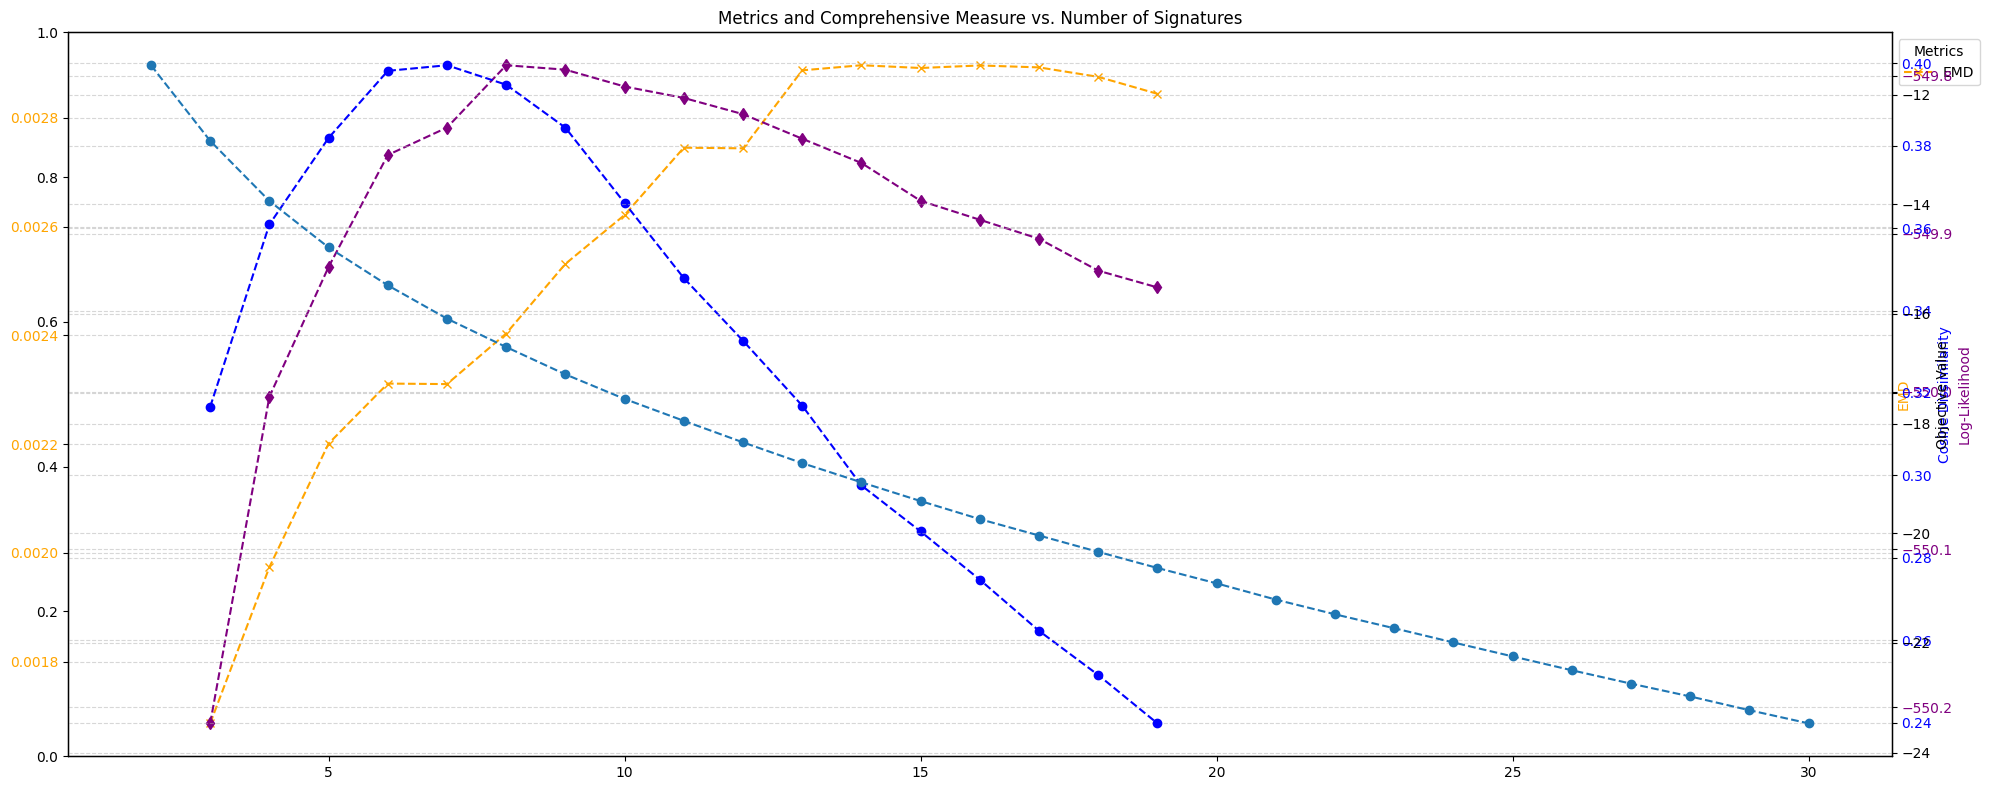

In [ ]:
M_path = "simulated_data_01_15/s_15_n_0.04_c_2000_5000_GRCh37_10a_56_10d_52_36_91_45_38_10c_14_18_7b_7a_23_19.csv"
decomposed_matrices_folder = f'outputs/signature_matrices/s_15_n_0.04_c_2000_5000_GRCh37_10a_56_10d_52_36_91_45_38_10c_14_18_7b_7a_23_19'
perform_matrix_analysis_combined_plot(M_path, decomposed_matrices_folder, iterations=100, k_values=range(3, 30), verbose=True)

In [ ]:
M_path = "simulated_data_01_15/s_15_n_0.02_c_5000_8000_GRCh37_10a_56_10d_52_36_91_45_38_10c_14_18_7b_7a_23_19.csv"
decomposed_matrices_folder = 'outputs/signature_matrices/s_15_n_0.02_c_5000_8000_GRCh37_10a_56_10d_52_36_91_45_38_10c_14_18_7b_7a_23_19'
perform_matrix_analysis_combined_plot(M_path, decomposed_matrices_folder, iterations=100, k_values=range(2, 30), verbose=False)

In [ ]:
path = ["simulated_data_01_15"]


M_path = "simulated_data_01_15/s_15_n_0.02_c_5000_8000_GRCh37_10a_56_10d_52_36_91_45_38_10c_14_18_7b_7a_23_19.csv"
decomposed_matrices_folder = 'outputs/signature_matrices/s_15_n_0.02_c_2000_5000_GRCh37_10a_56_10d_52_36_91_45_38_10c_14_18_7b_7a_23_19'
perform_matrix_analysis_combined_plot(M_path, decomposed_matrices_folder, iterations=100, k_values=range(2, 30), verbose=False)